<H1>Predicting Flight Delays</H1>
<H3>by Michael Klear</H3>
Using <a href='http://stat-computing.org/dataexpo/2009/the-data.html'>this ASA dataset</a> of historic flights, I built a simple nearest neighbors model to estimate flight tardiness.<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

The model I built uses only information available at the time of flight departure, and should work at any arbitrary time to predict the arrival delay of a flight leaving now. We'll look at the first week of Decemeber, 1999.

In [2]:
data = pd.read_csv('1999.csv.bz2')
december = data[data.Month == 12].copy()
del data
first_week = december[december.DayofMonth <= 7].copy()
del december
data = first_week
#Drop cancelled and diverted flights
data = data[data.Cancelled == 0]
data = data[data.Diverted == 0]
df = data

To evaluate my model, I use delay groups. Each group represents a different degree of delay. Any arrival delay of less than 30 minutes is in group zero (including on-time arrivals).

In [3]:
def assign_delay_group(arrival_delay):
    '''Takes an arrival delay in minutes and returns a list of 
    group numbers. The groups correspond to the following encoding:
    == 0 if less than 30 minutes late (on time), 
    == 1 if 30-45 minutes late, 
    == 2 if 45-60 min late, 
    == 3 if 60-90, 
    == 4 if 90-120, 
    == 5 if 120-180,
    == 6 if 180-240,
    == 7 if more than 240
    '''
    d = int(arrival_delay)
    if d < 30:
        return 0
    if 30 <= d < 45:
        return 1
    if 45 <= d < 60:
        return 2
    if 60 <= d < 90:
        return 3
    if 90 <= d < 120:
        return 4
    if 120 <= d < 180:
        return 5
    if 180 <= d < 240:
        return 6
    if 240 <= d:
        return 7
    else:
        raise Exception('Error: unrecognized input')
        
def get_day(year, month, day, count_forward=True):
    """Takes a year, month of the year(1-12), and day of the month(1-31).
    Returns the number of days from the beginning of the year (Jan 1==1).
    Keyword 'count_forward' (default True) specifies if to count days from beginning
    of year. If False, returns number of days until end of year.
    """
    days_common = {
        1 : 0,
        2 : 31,
        3 : 59,
        4 : 90,
        5 : 120,
        6 : 151,
        7 : 181,
        8 : 212,
        9 : 243,
        10 : 273,
        11 : 304,
        12 : 334
    }
    is_leap_year = bool()
    if year % 4 != 0:
        is_leap_year = False
    elif year % 100 != 0:
        is_leap_year = True
    elif year % 400 != 0:
        is_leap_year = False
    else:
        is_leap_year = True
    result = days_common[month]
    if is_leap_year and month > 2:
        result += 1
    result += day
    if count_forward:
        return result
    else:
        if is_leap_year:
            return (366 - result)
        else:
            return (365 - result)

In [4]:
df['day_of_year'] = df[['Year', 'Month', 'DayofMonth']].apply(lambda x: get_day(*x), axis=1)
df['arr_delay_group'] = df.ArrDelay.apply(assign_delay_group)

Differences between departure delay and arrival delay are important. If this split was always zero, arrival delay would always be equivalent to departure delay. We see later that this is not the case. My model works to predict the following metric:

In [5]:
df['dep_arr_delay_split'] = df.ArrDelay - df.DepDelay

I use the following function to evaluate my model performance based on the delay groups it predicts:

In [6]:
def eval_performance(Y_, Y_true):
    """Takes a list of predicted arrival delays (Y_) and a matching list of actual
    arrival delays (Y_true) and evaluates them based on delay groups.
    """
    Y_ = list(pd.Series(Y_).apply(assign_delay_group))
    Y_true = list(pd.Series(Y_true).apply(assign_delay_group))
    results = pd.DataFrame()
    results['true_group'] = Y_true
    results['predicted_group'] = Y_
    results['correct'] = np.where(results.true_group == results.predicted_group, 1, 0)
    results['off_by'] = np.abs(results.true_group - results.predicted_group)
    print('score: ', results.correct.sum()/len(results))
    results[results.correct==0].true_group.hist(bins=7);
    plt.title('True Arrival Groups of Misclassified Flights');
    plt.xlabel('True Arrival Group');
    plt.ylabel('Number of Misclassified Flights')
    plt.show();
    results[results.correct==0].off_by.hist(bins=7);
    plt.title('"Off By" Numer of Groups for Misclassified Flights');
    plt.xlabel('Off By Number of Groups');
    plt.ylabel('Number of Misclassified Flights')
    plt.show();
    print(results.head())


We can see how the "null model" performs (simply setting arrival delay equal to departure delay):

score:  0.942901102658


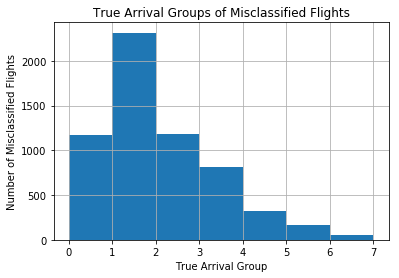

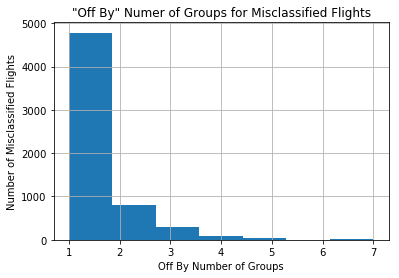

   true_group  predicted_group  correct  off_by
0           0                0        1       0
1           0                0        1       0
2           0                0        1       0
3           0                0        1       0
4           0                0        1       0


In [63]:
eval_performance(df.DepDelay, df.ArrDelay)

<H2>Features</H2>
The idea with my model is to use K nearest neighbors to ask "how are similar recent flights deviating from planned flight time?" This information may allow me to improve on the null model performance.<br>
I'll use destination airport location (lat and long), average flight direction in terms of lat and long, distance, and a scaled departure delay to describe "similar" flights.

In [8]:
#Load up dataset with lat/long info for airports.
coords = pd.read_csv('Airport_Codes_mapped_to_Latitude_Longitude_in_the_United_States.csv')
fca_row = pd.DataFrame(columns=coords.columns, index=[len(coords)])
fca_row['locationID'] = 'FCA'
fca_row['Latitude'] = 48.310556
fca_row['Longitude'] = -114.256111
coords = pd.concat([coords, fca_row], axis=0)

In [9]:
for org in df.Origin.unique():
    if org not in list(coords.locationID):
        print(org)

In [10]:
df['org_latitude'] = df.Origin.apply(lambda x: float(coords[coords.locationID == x].Latitude))
print('did a thing!')
df['org_longitude'] = df.Origin.apply(lambda x: float(coords[coords.locationID == x].Longitude))
print('did another thing!')
df['dest_latitude'] = df.Dest.apply(lambda x: float(coords[coords.locationID == x].Latitude))
print('did thing 3!')
df['dest_longitude'] = df.Dest.apply(lambda x: float(coords[coords.locationID == x].Longitude))
print('all the things!!')

did a thing!
did another thing!
did thing 3!
all the things!!


In [15]:
def get_direction_lat(olat, olong, dlat, dlong):
    """Takes origin lat and long and destination lat and long and returns
    a tuple: mean trip direction lat (N-S), mean trip direction long (W-E)
    """
    lat_disp = dlat - olat
    long_disp = dlong - olong
    dist_sq = (lat_disp**2) + (long_disp**2)
    dist = sqrt(dist_sq)
    return lat_disp/dist

def get_direction_long(olat, olong, dlat, dlong):
    """Takes origin lat and long and destination lat and long and returns
    a tuple: mean trip direction lat (N-S), mean trip direction long (W-E)
    """
    lat_disp = dlat - olat
    long_disp = dlong - olong
    dist_sq = (lat_disp**2) + (long_disp**2)
    dist = sqrt(dist_sq)
    return long_disp/dist

df['lat_dir'] = df[['org_latitude', 'org_longitude', 'dest_latitude', 'dest_longitude']].apply(lambda x: get_direction_lat(*x), axis=1)
df['long_dir'] = df[['org_latitude', 'org_longitude', 'dest_latitude', 'dest_longitude']].apply(lambda x: get_direction_long(*x), axis=1)
    

In [16]:
distance_scale = 560 * 24 #scale by roughly the distance a plane can fly in a day
df['dist_scaled'] = df.Distance/distance_scale

In [54]:
def get_dta(day, dep_time, arr_time):
    """Returns arrival day and time as a float, where the decimal is the time
    as a fraction of the day. Departure time needed to determine if arrives tomorrow.
    """
    result = day
    if dep_time > arr_time:
        result += 1
    min_scaled = 100*(float(str(arr_time)[-2:])/60)
    time_scaled = int(float((str(arr_time)[:-2] + str(min_scaled))))
    time_frac = time_scaled/2399
    return result + time_frac

df['date_time_arrival'] = df[['day_of_year', 'DepTime', 'ArrTime']].apply(lambda x: get_dta(*x), axis=1)

def get_dtd(day, dep_time):
    """Returns arrival day and time as a float, where the decimal is the time
    as a fraction of the day. Departure time needed to determine if arrives tomorrow.
    """
    result = day
    min_scaled = 100*(float(str(dep_time)[-2:])/60)
    time_scaled = int(float((str(dep_time)[:-2] + str(min_scaled))))
    time_frac = time_scaled/2399
    return result + time_frac

df['date_time_departure'] = df[['day_of_year', 'DepTime']].apply(lambda x: get_dtd(*x), axis=1)

In [61]:
def get_slice(data, dtd):
    """Slices data to get necessary flights for model.
    Returns slice of dataframe where current dta=0 and all
    previous times count back from there.
    """
    result = data[data.date_time_departure > dtd][data.date_time_departure < (dtd+2)]
    result.date_time_departure = result.date_time_departure - result.date_time_departure.max()
    return result

In [49]:
df['dep_delay_scaled'] = df.DepDelay/60

In [50]:
ft = [
    'date_time_departure',
    'dest_latitude',
    'dest_longitude',
    'lat_dir',
    'long_dir',
    'dist_scaled',
    'dep_delay_scaled'
]

estimation number:  50000


/home/alliedtoasters/anaconda3/envs/dspy3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


estimation number:  50500
estimation number:  51000
estimation number:  51500
estimation number:  52000
estimation number:  52500
estimation number:  53000
estimation number:  53500
estimation number:  54000
estimation number:  54500
estimation number:  55000
estimation number:  55500
estimation number:  56000
estimation number:  56500
estimation number:  57000
estimation number:  57500
estimation number:  58000
estimation number:  58500
estimation number:  59000
estimation number:  59500
Model performance: 

score:  0.9403


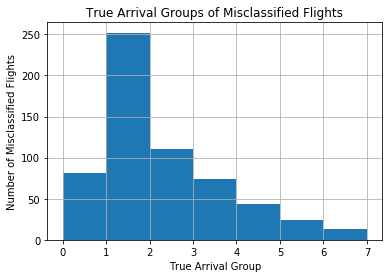

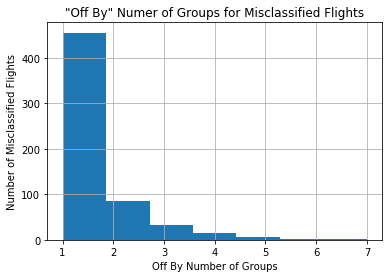

   true_group  predicted_group  correct  off_by
0           0                0        1       0
1           0                0        1       0
2           0                0        1       0
3           0                0        1       0
4           0                0        1       0
Null Model Performance: 

score:  0.9397


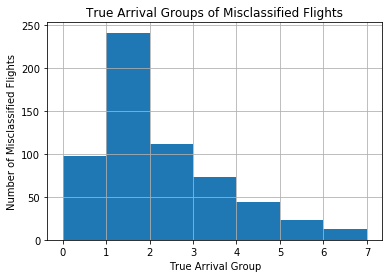

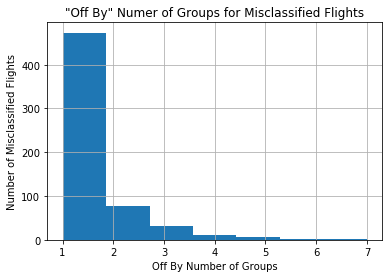

   true_group  predicted_group  correct  off_by
0           0                0        1       0
1           0                0        1       0
2           0                0        1       0
3           0                0        1       0
4           0                0        1       0


In [62]:
ordered = df.loc[df.date_time_departure.sort_values(ascending=True).index]
pred_dad = []
start_val = 50000
stop_val = 60000
for n in range (start_val, stop_val):
    if n % 500 == 0:
        print('estimation number: ', n)
    slc = get_slice(ordered, ordered.iloc[n].date_time_departure)
    X = slc[ft]
    Y = slc['dep_arr_delay_split']
    mod = KNeighborsRegressor(n_neighbors=7, weights=None)
    mod.fit(X, Y)
    pred_dad.append(int(mod.predict(np.array(ordered[ft].iloc[n]).reshape(1, -1))))
    
    
Y_ = ordered.iloc[start_val:stop_val].DepDelay + pred_dad
Y_act = ordered.iloc[start_val:stop_val].ArrDelay
print('Model performance: \n')
eval_performance(Y_, Y_act)

print('Null Model Performance: \n')
Y_ = ordered.iloc[start_val:stop_val].DepDelay
Y_act = ordered.iloc[start_val:stop_val].ArrDelay
eval_performance(Y_, Y_act)

score:  0.9397


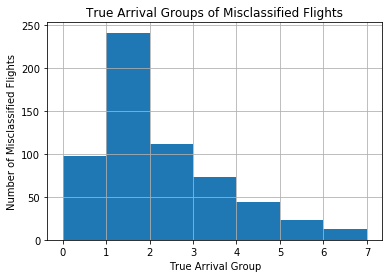

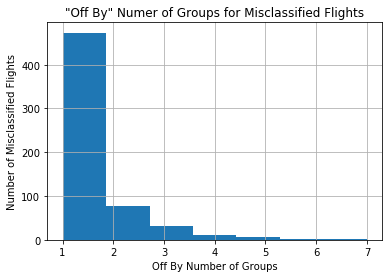

   true_group  predicted_group  correct  off_by
0           0                0        1       0
1           0                0        1       0
2           0                0        1       0
3           0                0        1       0
4           0                0        1       0


In [56]:
Y_ = ordered.iloc[start_val:stop_val].DepDelay
Y_act = ordered.iloc[start_val:stop_val].ArrDelay
eval_performance(Y_, Y_act)

In [ ]:
X = df[ft]
Y = df['dep_arr_delay_split']

df_train = df[:cutoff]
X_train = X[:cutoff]
Y_train = Y[:cutoff]

df_test = df[cutoff:]
X_test = X[cutoff:]
Y_test = Y[cutoff:]

In [ ]:
knn = KNeighborsRegressor(n_neighbors=6, weights=None)
knn = knn.fit(X_train, Y_train)
pred_dad = knn.predict(X_test)

In [ ]:
pred = df_test.DepDelay + pred_dad
act = df_test.ArrDelay
eval_performance(pred, act)

In [ ]:
arr_time = 130
min_scaled = 100*(int(str(arr_time)[-2:])/60)
print(min_scaled)
result = str(arr_time)[:-2] + str(min_scaled)
int(float(result))